In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
template = gnn.Dataset("../data/template",make_template=True)

In [3]:
model = gnn.GoldenGCN.load_from_checkpoint(
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/models/golden_classifier/lightning_logs/version_2/checkpoints/epoch=24-step=9024.ckpt"
    ,dataset=template).to(device=gnn.config.device)

In [4]:
signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])

In [5]:
for tree in signaltrees: tree.color=None

In [6]:
def get_tree_graph(tree, ver='testing', path='../data'):
    sample = tree.sample
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=100, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [7]:
signaltrees.apply(get_tree_graph)

[None, None, None]

In [8]:
batch = next(iter(signaltrees[0].graphs)).to(gnn.config.device)

In [9]:
with torch.no_grad():
    node_o,edge_o = model.predict(batch)

In [10]:
node_i, node_j = batch.edge_index

In [11]:
i_to_j = node_i < node_j
j_to_i = node_j < node_i

In [12]:
signaltrees.nfound_presel

[<Array [5, 8, 5, 6, 6, 6, ... 6, 7, 7, 7, 7, 6] type='50673 * int32'>, <Array [7, 7, 7, 6, 7, 6, ... 5, 8, 8, 8, 8, 6] type='64127 * int32'>, <Array [5, 7, 6, 7, 7, 8, ... 6, 7, 7, 8, 6, 6] type='72180 * int32'>]

In [13]:
edge_o_diff = (edge_o[i_to_j]-edge_o[j_to_i]).cpu().numpy()

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

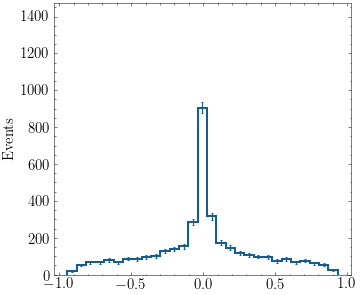

In [14]:
hist_multi([edge_o_diff])

In [15]:
signaltrees.apply(build_all_dijets)

[None, None, None]

In [16]:
def predict_tree(tree):
    node_scores, edge_itoj_scores, edge_jtoi_scores = [],[],[]
    for graph in tree.graphs:
        node_score, edge_score = model.predict(graph.to(gnn.config.device))
        node_scores.append(node_score)
        
        node_i, node_j = graph.edge_index
        i_to_j = node_i < node_j
        j_to_i = node_j < node_i
        edge_itoj_scores.append(edge_score[i_to_j])
        edge_jtoi_scores.append(edge_score[j_to_i])
        
    node_scores = torch.cat(node_scores).cpu().numpy()
    edge_itoj_scores = torch.cat(edge_itoj_scores).cpu().numpy()
    edge_jtoi_scores = torch.cat(edge_jtoi_scores).cpu().numpy()
    
    node_scores = ak.unflatten(node_scores,ak.num(tree.jet_pt))
    edge_itoj_scores = ak.unflatten(edge_itoj_scores,ak.num(tree.dijet_pt))
    edge_jtoi_scores = ak.unflatten(edge_jtoi_scores,ak.num(tree.dijet_pt))
    
    tree.extend(
        jet_score = node_scores,
        dijet_itoj_score = edge_itoj_scores,
        dijet_jtoi_score = edge_jtoi_scores,
    )

In [17]:
signaltrees.apply(predict_tree)

[None, None, None]

In [18]:
edge_itoj_metrics = signaltrees.apply(lambda t : gnn.ROCMetric(1*(t.dijet_signalId>-1),t.dijet_itoj_score))
edge_jtoi_metrics = signaltrees.apply(lambda t : gnn.ROCMetric(1*(t.dijet_signalId>-1),t.dijet_jtoi_score))

(<Figure size 1152x360 with 2 Axes>,
 <AxesSubplot:label="['MX_700_MY_300', 'MX_900_MY_400', 'MX_1200_MY_500']", ylabel='Events'>)

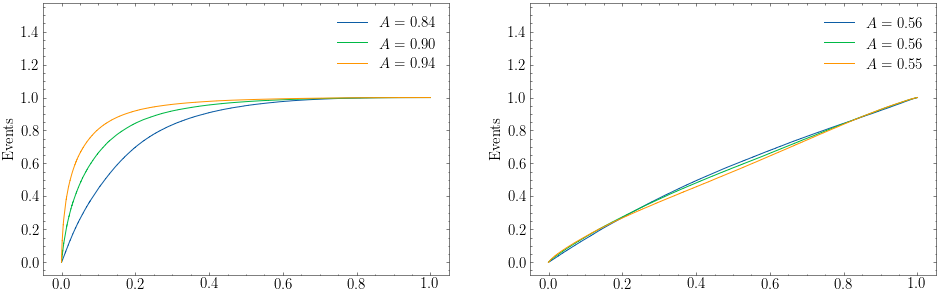

In [19]:
fig,axs = plt.subplots(ncols=2,figsize=(16,5))

graph_arrays(
    edge_itoj_metrics.fpr.list,
    edge_itoj_metrics.tpr.list,
    label=signaltrees.sample,
    legend=True,
    figax=(fig,axs[0])
)

graph_arrays(
    edge_jtoi_metrics.fpr.list,
    edge_jtoi_metrics.tpr.list,
    label=signaltrees.sample,
    legend=True,
    figax=(fig,axs[1])
)

In [20]:
signaltrees.apply(lambda t : select_higgs(t, field='itoj_score', nhiggs=4))

[None, None, None]

In [21]:
def get_bjets_from_higgs(tree):
    j1Idx = tree.gnn_higgs_j1Idx
    j2Idx = tree.gnn_higgs_j2Idx
    jIdxs = ak.sort(ak.concatenate([j1Idx,j2Idx],axis=-1),axis=-1)
    jets = get_collection(tree,'jet')[jIdxs]
    jets = rename_collection(jets,'gnn_bjet','jet')
    tree.extend(
        **unzip_records(jets)
    )

In [22]:
signaltrees.apply(get_bjets_from_higgs)

[None, None, None]

In [23]:
higgs_itoj_metrics = signaltrees.apply(lambda t : gnn.ROCMetric(1*(t.gnn_higgs_signalId>-1),t.gnn_higgs_itoj_score))
higgs_jtoi_metrics = signaltrees.apply(lambda t : gnn.ROCMetric(1*(t.gnn_higgs_signalId>-1),t.gnn_higgs_jtoi_score))

(<Figure size 1152x360 with 2 Axes>,
 <AxesSubplot:label="['MX_700_MY_300', 'MX_900_MY_400', 'MX_1200_MY_500']", ylabel='Events'>)

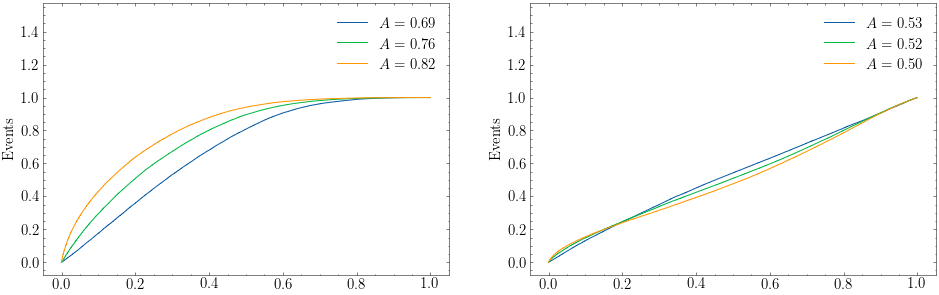

In [24]:
fig,axs = plt.subplots(ncols=2,figsize=(16,5))

graph_arrays(
    higgs_itoj_metrics.fpr.list,
    higgs_itoj_metrics.tpr.list,
    label=signaltrees.sample,
    legend=True,
    figax=(fig,axs[0])
)

graph_arrays(
    higgs_jtoi_metrics.fpr.list,
    higgs_jtoi_metrics.tpr.list,
    label=signaltrees.sample,
    legend=True,
    figax=(fig,axs[1])
)

In [25]:
higgs_itoj_metrics.get_wps()

[array([[0.2       , 0.3594287 , 0.86555296],
       [0.1       , 0.17604827, 0.89741147],
       [0.05      , 0.08462537, 0.91696131]]), array([[0.2       , 0.50855038, 0.88785797],
       [0.1       , 0.29520939, 0.92120892],
       [0.05      , 0.16361723, 0.93876189]]), array([[0.2       , 0.63861219, 0.90056628],
       [0.1       , 0.43090358, 0.93748373],
       [0.05      , 0.28255816, 0.95447248]])]

In [26]:
signaltrees.extend(kwargs = lambda t : dict(
    **build_collection(t,'H\dY\d_b\d','bjet',ptordered=True)
))

[None, None, None]

In [27]:
signaltrees.extend(kwargs = lambda t : dict(
    **build_collection(t,'H\dY\d','higgs',ptordered=True)
))

[None, None, None]

In [28]:
def count_jets(t):
    nfound_gnn = ak.sum(t.gnn_bjet_signalId>-1,axis=-1)
    t.extend(nfound_gnn=nfound_gnn)
signaltrees.apply(count_jets)

[None, None, None]

In [29]:
def count_higgs(t):    
    nfound_h = ak.sum((t.higgs_b1_genHflag != -1) & (t.higgs_b2_genHflag != -1) & (t.higgs_b1_genHflag == t.higgs_b2_genHflag),axis=-1)
    nfound_gnn_h = ak.sum(t.gnn_higgs_signalId>-1,axis=-1)
    t.extend(
        nfound_h=nfound_h,
        nfound_gnn_h=nfound_gnn_h
    )
signaltrees.apply(count_higgs)

[None, None, None]

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='GNN Selected DiJet Mass', ylabel='Fraction of Events'>,
        <AxesSubplot:xlabel='Min Mass Spread DiJet Mass', ylabel='Fraction of Events'>],
       dtype=object))

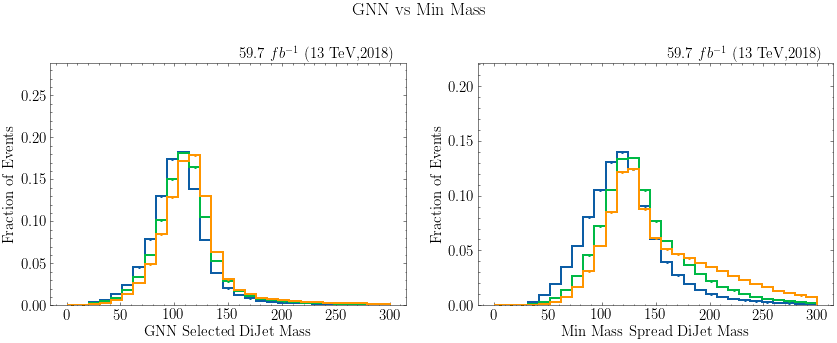

In [30]:
study.quick(signaltrees,varlist=['gnn_higgs_m','higgs_m'],xlabels=["GNN Selected DiJet Mass","Min Mass Spread DiJet Mass"],dim=(1,2),density=1,title='GNN vs Min Mass')

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='nfound_select', ylabel='Fraction of Events Above (CDF)'>,
        <AxesSubplot:xlabel='nfound_gnn', ylabel='Fraction of Events Above (CDF)'>],
       dtype=object))

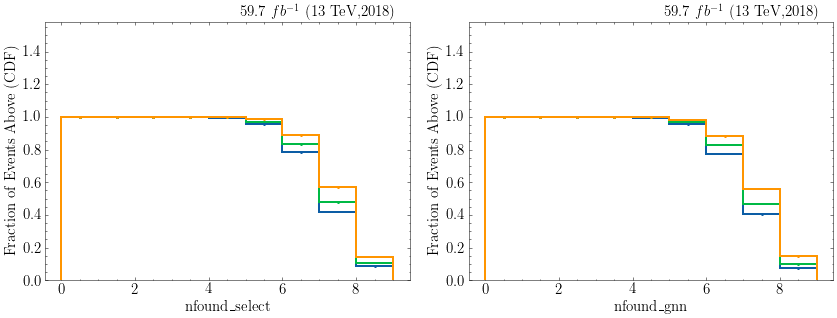

In [31]:
study.quick(
    signaltrees,
    varlist=['nfound_select','nfound_gnn'],
    cumulative=-1,
)

(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='nfound_h', ylabel='Fraction of Events Above (CDF)'>,
        <AxesSubplot:xlabel='nfound_gnn_h', ylabel='Fraction of Events Above (CDF)'>],
       dtype=object))

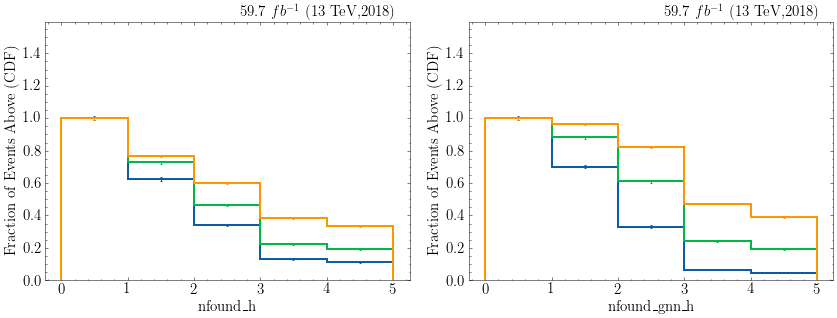

In [32]:
study.quick(
    signaltrees,
    masks=lambda t : t.nfound_presel==8,
    varlist=['nfound_h','nfound_gnn_h'],
    cumulative=-1,
)

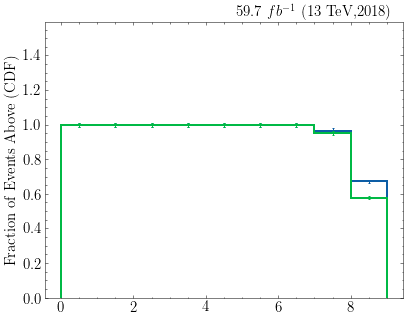

(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:ylabel='Fraction of Events Above (CDF)'>)

In [33]:
study.overlay(
    signaltrees,
    masks=lambda t : t.nfound_presel==8,
    varlist=['nfound_select','nfound_gnn'],
    cumulative=-1,
    # legend=True,
)

0.16957431960921143
0.07998915401301518


(<Figure size 384x360 with 2 Axes>,
 <AxesSubplot:ylabel='Fraction of Events Above (CDF)'>)

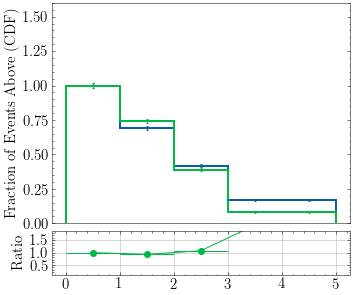

In [34]:
tree = signaltrees[0]

mask = tree.nfound_select == 8
nfound_mass = tree.nfound_h[mask]

print(np.sum(nfound_mass==4)/np.sum(mask))

mask = ak.sum(tree.gnn_bjet_signalId>-1,axis=-1)==8
nfound_gnn = tree.nfound_gnn_h[mask]

print(np.sum(nfound_gnn==4)/np.sum(mask))

hist_multi([nfound_mass,nfound_gnn],ratio=True,cumulative=-1)